<a href="https://colab.research.google.com/github/thehydrowave/Adversarial-diffusion-distillation-pokemon/blob/main/ADD_part2_Naruto_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Adversarial Diffusion Distillation (ADD) - Projet Naruto

Ce notebook implémente l'entraînement d'un modèle student rapide à partir d'un modèle Stable Diffusion LoRA (teacher), selon le papier [Adversarial Diffusion Distillation (ADD)](https://arxiv.org/abs/2311.17042).

In [1]:
!pip install numpy==1.26.4 diffusers==0.25.1 transformers==4.37.2 accelerate==0.27.2 \
datasets==2.17.0 huggingface_hub==0.25.0 peft==0.7.1 fsspec==2023.6.0 \
torch==2.2.2 torchvision==0.17.2 pandas==2.2.2 timm --no-cache-dir --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 145.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 265.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 174.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 169.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 191.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 336.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 349.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 343.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 343.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import numpy as np
from diffusers import StableDiffusionPipeline
import torch
import torch.nn as nn
import timm
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy

print(np.__version__)
print("✅ Tout fonctionne avec diffusers.")

/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


1.26.4
✅ Tout fonctionne avec diffusers.


In [2]:
# 🔁 Injection LoRA et chargement manuel depuis .bin
from diffusers.models.attention_processor import LoRAAttnProcessor

# Initialize teacher before using it
teacher = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda" if torch.cuda.is_available() else "cpu")

def inject_lora_modules(unet):
    print("⚙️ Injection des modules LoRA...")
    cross_attention_dim = unet.config.cross_attention_dim
    attention_dims = {
        "mid_block": unet.config.block_out_channels[-1],
        "up_blocks.3": unet.config.block_out_channels[0],
        "up_blocks.2": unet.config.block_out_channels[1],
        "up_blocks.1": unet.config.block_out_channels[2],
        "up_blocks.0": unet.config.block_out_channels[3],
        "down_blocks.0": unet.config.block_out_channels[0],
        "down_blocks.1": unet.config.block_out_channels[1],
        "down_blocks.2": unet.config.block_out_channels[2],
        "down_blocks.3": unet.config.block_out_channels[3],
    }

    attn_processors = {}
    for name, processor in unet.attn_processors.items():
        for block_key in attention_dims:
            if name.startswith(block_key):
                hidden_size = attention_dims[block_key]
                is_cross_attention = name.endswith("attn2.processor")

                attn_processors[name] = LoRAAttnProcessor(
                    hidden_size=hidden_size,
                    cross_attention_dim=cross_attention_dim if is_cross_attention else None
                )
                break
        else:
            attn_processors[name] = processor

    unet.set_attn_processor(attn_processors)
    print(f"✅ LoRA injecté dans {sum(isinstance(p, LoRAAttnProcessor) for p in attn_processors.values())} couches.")

def load_lora_weights_from_bin(unet, lora_path):
    print(f"🔍 Chargement des poids LoRA depuis : {lora_path}")
    lora_weights = torch.load(lora_path)
    updated = 0
    for full_key, module in unet.attn_processors.items():
        if hasattr(module, 'load_state_dict'):
            prefix = full_key + "."
            sub_state_dict = {k[len(prefix):]: v for k, v in lora_weights.items() if k.startswith(prefix)}
            if sub_state_dict:
                try:
                    module.load_state_dict(sub_state_dict, strict=False)
                    updated += 1
                except Exception as e:
                    print(f"⚠️ Erreur pour {full_key} : {e}")
    print(f"✅ {updated}/{len(unet.attn_processors)} modules LoRA mis à jour.")

inject_lora_modules(teacher.unet)
load_lora_weights_from_bin(teacher.unet, "./pytorch_lora_weights.bin")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


⚙️ Injection des modules LoRA...
✅ LoRA injecté dans 0 couches.
🔍 Chargement des poids LoRA depuis : ./pytorch_lora_weights.bin
✅ 32/32 modules LoRA mis à jour.


In [3]:
# 🧠 Initialiser le student avec mêmes modules LoRA
student = copy.deepcopy(teacher)
student.scheduler.set_timesteps(num_inference_steps=4)
# student.train()  # ❌ Pas nécessaire, les modules entraînables sont gérés via student.unet.train()

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a model that accepts 64x64 images
        # or modify the existing one to accept 64x64
        self.backbone = timm.create_model('resnet18', pretrained=True, num_classes=1) # Example with ResNet18
        #self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=1, img_size=64)  # Tiny ViT

    def forward(self, x):
        return self.backbone(x)

# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
discriminator = Discriminator().to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [5]:
# 📥 Dataset Naruto
dataset = load_dataset("lambdalabs/naruto-blip-captions", split="train")
dataset = dataset.select(range(128))

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [6]:
def transform_example(example):
    image = example["image"].convert("RGB")
    example["pixel_values"] = transform(image)
    return example

dataset = dataset.map(transform_example)

def collate_fn(batch):
    pixel_values = torch.stack([
        torch.tensor(x["pixel_values"]) if not isinstance(x["pixel_values"], torch.Tensor) else x["pixel_values"]
        for x in batch
    ])
    prompts = [x["text"] for x in batch]
    return pixel_values, prompts


train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [9]:
# 🔁 Training Loop ADD (SDS + GAN + distillation intermédiaire)
lambda_adv = 0.5
optimizer_student = torch.optim.Adam(student.unet.parameters(), lr=1e-5)
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-5)
adversarial_loss_fn = nn.BCEWithLogitsLoss()
mse_loss_fn = nn.MSELoss()

# Enable mixed precision training
# Removed GradScaler as it's not needed for FP16 training
# scaler = torch.cuda.amp.GradScaler()  # Create a GradScaler object

# Gradient Accumulation (Optional, uncomment if needed)
# accum_iter = 2  # Accumulate gradients over 2 iterations

for epoch in range(2):
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch}")
    for idx, (pixel_values, prompts) in enumerate(loop): # Added idx for gradient accumulation
        pixel_values = pixel_values.to(device, dtype=torch.float16)
        batch_size = pixel_values.shape[0]

        # Encoder les prompts
        inputs = teacher.tokenizer(prompts, padding="max_length", truncation=True, return_tensors="pt").to(device)
        encoder_hidden_states = teacher.text_encoder(**inputs).last_hidden_state

        # Sample un timestep t aléatoire
        t = torch.randint(0, teacher.scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

        # Encode les images en latents (teacher)
        with torch.no_grad():
            latents = teacher.vae.encode(pixel_values).latent_dist.sample() * 0.18215
            noise = torch.randn_like(latents)
            x_t = teacher.scheduler.add_noise(latents, noise, t)
            target = noise

        # --- Entraînement du Discriminateur ---
        with torch.no_grad():
            gen_latents = student.vae.decode(latents).sample
            gen_images = torch.clamp((gen_latents / 2 + 0.5), 0, 1)

        discriminator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Cast the inputs to float32 for the discriminator
        real_output = discriminator(pixel_values.float())
        fake_output = discriminator(gen_images.detach().float())
        gen_output = discriminator(gen_images.float())

        d_loss_real = adversarial_loss_fn(real_output, real_labels)
        d_loss_fake = adversarial_loss_fn(fake_output, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_loss.backward()
        optimizer_disc.step()

        # --- Entraînement du Student ---
        student.unet.train()
        optimizer_student.zero_grad()

        # Use autocast for mixed precision training
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            noise_pred = student.unet(x_t, t, encoder_hidden_states).sample
            loss_sds = mse_loss_fn(noise_pred, target)
            gen_output = discriminator(gen_images.float())
            loss_adv = adversarial_loss_fn(gen_output, real_labels)
            s_loss = loss_sds + lambda_adv * loss_adv

        # Gradient Accumulation (Optional, uncomment if needed)
        # s_loss = s_loss / accum_iter  # Normalize the loss

        # Removed scaler as it's not needed for FP16 training
        # scaler.scale(s_loss).backward()

        s_loss.backward()
        # if (idx + 1) % accum_iter == 0: # Uncomment for gradient accumulation
        # Removed the manual casting of gradients to FP16
        # scaler.step(optimizer_student)
        # scaler.update()

        # optimizer_student.zero_grad() # Uncomment for gradient accumulation
        # Removed scaler as it's not needed for FP16 training
        # scaler.step(optimizer_student)
        # scaler.update()

        optimizer_student.step()


        loop.set_postfix(d_loss=d_loss.item(), s_loss=s_loss.item(), sds=loss_sds.item())

Epoch 1: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s, d_loss=0.687, s_loss=nan, sds=nan]


  0%|          | 0/4 [00:00<?, ?it/s]

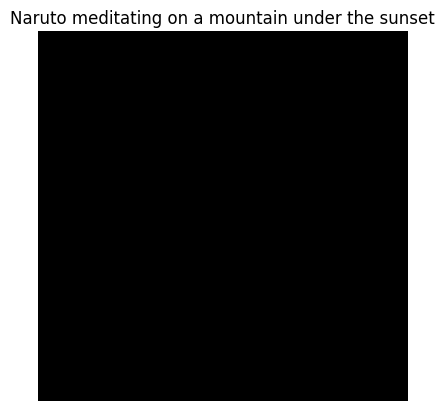

In [18]:
from matplotlib import pyplot as plt

# Désactiver le filtre NSFW
student.safety_checker = None


# Passage en mode évaluation (optionnel mais propre)
student.unet.eval()
student.vae.eval()
student.text_encoder.eval()

# Prompt
prompt = "Naruto meditating on a mountain under the sunset"

# Génération
with torch.autocast("cuda"):
    result = student(prompt=prompt, num_inference_steps=4)

# Affichage
image = result.images[0]
plt.imshow(image)
plt.axis("off")
plt.title(prompt)
plt.show()



  0%|          | 0/10 [00:00<?, ?it/s]

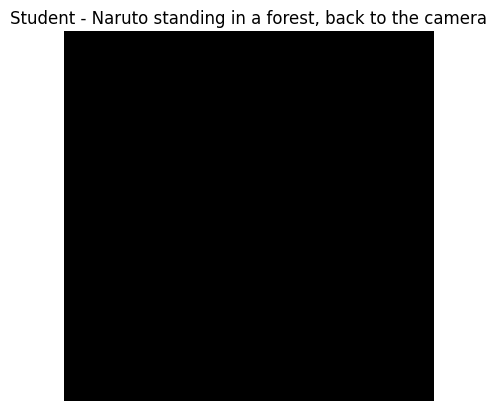

In [19]:
student.safety_checker = None
prompt = "Naruto standing in a forest, back to the camera"
with torch.autocast("cuda"):
    result = student(prompt=prompt, num_inference_steps=10)  # essayer plus de steps

image = result.images[0]
plt.imshow(image)
plt.axis("off")
plt.title("Student - " + prompt)
plt.show()


In [21]:
with torch.no_grad():
    latents = teacher.vae.encode(image_tensor).latent_dist.sample() * 0.18215
    noise = torch.randn_like(latents)
    t = torch.randint(0, 1000, (1,), device=device).long()
    x_t = teacher.scheduler.add_noise(latents, noise, t)

    noise_pred = student.unet(x_t, t, encoder_hidden_states).sample

    print("MSE noise_pred vs real:", torch.nn.functional.mse_loss(noise_pred, noise).item())


NameError: name 'image_tensor' is not defined

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/models/attention_processor.py:1871: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(


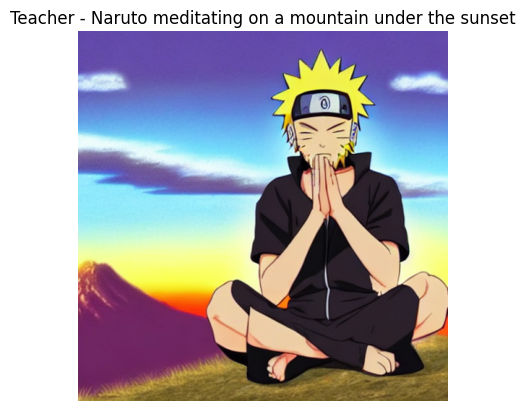

In [20]:
teacher.safety_checker = None
teacher.to("cuda")
teacher.unet.eval()
teacher.text_encoder.eval()
teacher.vae.eval()

prompt = "Naruto meditating on a mountain under the sunset"

with torch.autocast("cuda"):
    result = teacher(prompt=prompt, num_inference_steps=50)  # classique

image = result.images[0]

from matplotlib import pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.title("Teacher - " + prompt)
plt.show()


---------------------------------------------------------------------------